# Pytorch
---
documentación: https://pytorch.org/docs/stable/index.html


In [1]:
import torchvision
import torch
import torchaudio
import torchtext

In [2]:
torch.__version__

'1.9.0'

## Modelos Pre-Entrenados

In [3]:
#Modelos de Visión
from torchvision import models

In [4]:
#Lista de Modelos
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [5]:
#Arquitectura Sola
alexnet = models.AlexNet()

<img src="./img/alexnet.png"/>

### Resnet

Modelo de ResNet: https://arxiv.org/pdf/1512.03385.pdf  <br>
Con minúscula ya es el modelo entrenado.

In [6]:
resnet = models.resnet101(pretrained=True)

In [7]:
#Transformaciones 
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

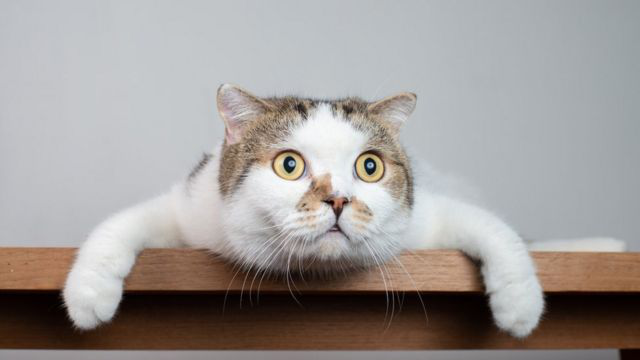

In [91]:
#Leer Imagen
img = Image.open("img/gato.jpg")
img

In [53]:
img_t = preprocess(img)
img_t.shape #RGB, Alto, Largo

torch.Size([3, 224, 224])

In [54]:
#Agregamos una dimensión en 0
batch_t = torch.unsqueeze(img_t, 0)
batch_t.shape

torch.Size([1, 3, 224, 224])

In [55]:
#Necesario
resnet.eval();

In [56]:
out = resnet(batch_t);
#10000 categorias probabilidad
out.shape

torch.Size([1, 1000])

In [57]:
_, index = torch.max(out, 1)
index

tensor([834])

Lista de indices imagent: https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b

In [58]:
#Transformamos txt en Lista de Clases
with open('./extras/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

print(type(labels))
len(labels)

<class 'list'>


1000

Función Softmax: https://es.wikipedia.org/wiki/Funci%C3%B3n_SoftMax

In [59]:
#Transformacion en probabilidades
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

In [60]:
# Label de la lista,  probabilidad de out
labels[index[0]], percentage[index[0]]

('suit, suit of clothes', tensor(46.4103, grad_fn=<SelectBackward>))

In [61]:
#Ordenamos de mayor a menor
_, indices = torch.sort(out, descending=True)

#Top 5
[(labels[idx], percentage[idx].item()) for idx in indices[0,0:5]]

[('suit, suit of clothes', 46.4102897644043),
 ('Windsor tie', 26.213687896728516),
 ('groom, bridegroom', 6.601017951965332),
 ('torch', 2.142266273498535),
 ('oboe, hautboy, hautbois', 1.8232696056365967)]

### Cycle-Gan

<img src="./img/cyclegan.png"/>

paper: https://arxiv.org/pdf/1703.10593.pdf <br>
video:https://youtu.be/AxrKVfjSBiA


In [64]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [66]:
netG = ResNetGenerator()

In [83]:
#Cargamos Modelos 
model_path = './extras/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [84]:
model_data.keys()

dict_keys(['model.1.weight', 'model.1.bias', 'model.4.weight', 'model.4.bias', 'model.7.weight', 'model.7.bias', 'model.10.conv_block.1.weight', 'model.10.conv_block.1.bias', 'model.10.conv_block.5.weight', 'model.10.conv_block.5.bias', 'model.11.conv_block.1.weight', 'model.11.conv_block.1.bias', 'model.11.conv_block.5.weight', 'model.11.conv_block.5.bias', 'model.12.conv_block.1.weight', 'model.12.conv_block.1.bias', 'model.12.conv_block.5.weight', 'model.12.conv_block.5.bias', 'model.13.conv_block.1.weight', 'model.13.conv_block.1.bias', 'model.13.conv_block.5.weight', 'model.13.conv_block.5.bias', 'model.14.conv_block.1.weight', 'model.14.conv_block.1.bias', 'model.14.conv_block.5.weight', 'model.14.conv_block.5.bias', 'model.15.conv_block.1.weight', 'model.15.conv_block.1.bias', 'model.15.conv_block.5.weight', 'model.15.conv_block.5.bias', 'model.16.conv_block.1.weight', 'model.16.conv_block.1.bias', 'model.16.conv_block.5.weight', 'model.16.conv_block.5.bias', 'model.17.conv_bloc

In [87]:
# Evaluamos El Modelo
netG.eval();

In [94]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

In [115]:
img = Image.open("./img/caballo2.jpeg")

In [116]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [117]:
result = netG(batch_t)

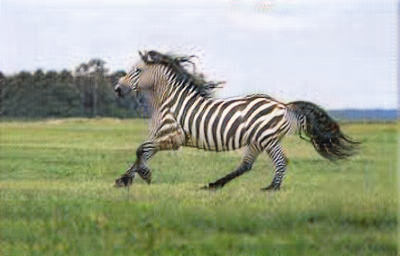

In [118]:
out_t = (result.data.squeeze()+1.0)/2.0
out_img = transforms.ToPILImage()(out_t)
out_img

## TorchHub

In [119]:
pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

Note: you may need to restart the kernel to use updated packages.


In [120]:

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images


Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/matute/.cache/torch/hub/master.zip
YOLOv5 🚀 2021-7-24 torch 1.9.0 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]

Fusing layers... 


Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


In [125]:
for f in ['zidane.jpg', 'bus.jpg']:
    torch.hub.download_url_to_file('https://ultralytics.com/images/' + f, f)

  0%|          | 0.00/165k [00:00<?, ?B/s]

  0%|          | 0.00/476k [00:00<?, ?B/s]

In [131]:
import cv2 
img1 = Image.open('zidane.jpg')  # PIL image
img2 = cv2.imread('bus.jpg')[..., ::-1]
imgs = [img1, img2]  # batch of images

In [132]:
# Inference
results = model(imgs, size=640)  # includes NMS

In [133]:
results.print()  
results.save()  # or .show()

image 1/2: 720x1280 2 persons, 2 ties
image 2/2: 1080x810 4 persons, 1 bus
Speed: 30.1ms pre-process, 154.3ms inference, 0.7ms NMS per image at shape (2, 3, 640, 640)
Saved 2 images to 'runs/detect/exp'


In [134]:
results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,749.472107,43.656921,1147.645752,704.565125,0.874176,0,person
1,433.666870,433.769470,517.575012,714.643982,0.688577,27,tie
2,115.053375,195.761292,1095.530029,708.221375,0.625422,0,person
3,986.198364,304.158997,1028.016602,420.192810,0.286980,27,tie
